# Property Analysis
The goal of this project is to scrape and analyze property listing information from the web. I am interested in residential property prices in Kuala Lumpur, Malaysia, as listed on [iProperty](https://www.iProperty.com.my).

# Imports

In [1]:
import numpy as np
np.random.seed(101)
import requests
import time
import os
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os
import re
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.linear_model
import sklearn.feature_selection
import sklearn.preprocessing
import sklearn.metrics
import keras.models
import keras.layers

Using TensorFlow backend.


# Scraping the Data
The amount of data to be scraped is, essentially, arbitrary. At the time of scraping the data (November 8th, 2018), there were a total of 2693 pages of residential property listings in Kuala Lumpur, which I scraped in their entirety. This took well over 5 hours, which is why I highly discourage you from running the cell below unless you are sure you have a lot of time to spare!

In [2]:
url_template = "https://www.iproperty.com.my/sale/kuala-lumpur/all-residential/?page={}"
first_page = 1
last_page = 2693

# This loop is designed to not download a page again based on page ID.
# That means all pages must be downloaded in one go to prevent missing 
# or duplicate entries.
for counter in range(first_page, last_page+1):
    page_out = "iproperty_kl/page_{}.html".format(counter)
    if os.path.exists(page_out):
        continue
        
    print("Processing page {} ...".format(counter))
    
    url = url_template.format(counter)
    response = requests.get(url)
    
    if response.status_code != 200:
        print("FAILED to process page {} ...".format(counter))
        continue
        
    with open(page_out, "w") as f:
        f.write(response.text)
    print("Done processing and waiting ...".format(counter))
    time.sleep(5)

Note that it is atypical to download an entire page due to the sheer amount of space required. However, in the interest of repeatability (this is data _science_ after all), I downloaded the pages first and then performed the actual scraping offline. These two steps can, of course, be merged into a single one.

A challenge with the scraping is that there are two distinct layouts. The first few pages have larger panels for the properties than the remaining pages. This different layout is achieved by changing the HTML tag structure and class identifiers slightly. While much of the information is accessible in the same way, the location and property type are not.



In [3]:
def scrape_listing(listing):
    # Determines the layout type
    is_big_panel = True if listing.find("span", attrs={
        "class": "phone-number"}) is not None else False

    try:
        price = listing.find("li", attrs={"class": "listing-primary-price-item"}).get_text()
    except AttributeError:
        price = None

    try:
        if is_big_panel:
            location = listing.find("p", attrs={
                "class": "row-one-left-col-listing-location"}).find("a").get_text()
        else:
            location = listing.find("div", attrs={"class": "fsKEtj"}).find("a").get_text()        
    except AttributeError:
        location = None

    try:
        if is_big_panel:
            prop_type = listing.find("p", attrs={"class": "property-type-content"}).get_text()
        else:
            prop_type = listing.find("div", attrs={"class": "eqkyrG"}).get_text()
    except AttributeError:
        prop_type = None

    try:
        prop_size = listing.find("li", attrs={
            "class": ["builtUp-attr", "landArea-attr"]}).find("a").get_text()
    except AttributeError:
        prop_size = None

    try:
        prop_furnished = listing.find(
            "li", attrs={"class": "furnishing-attr"}).find("a").get_text()
    except AttributeError:
        prop_furnished = None

    try:
        rooms = listing.find("li", attrs={"class": "bedroom-facility"}).get_text()
    except AttributeError:
        rooms = None

    try:
        bathrooms = listing.find("li", attrs={"class": "bathroom-facility"}).get_text()
    except AttributeError:
        bathrooms = None

    try:
        carParks = listing.find("li", attrs={"class": "carPark-facility"}).get_text()
    except AttributeError:
        carParks = None

    try:
        # All links in the listing lead to the same page!
        url = listing.find("a")["href"]
    except AttributeError:
        url = None

    return pd.Series(data={
        "Location": location,
        "Price": price, 
        "Rooms": rooms,
        "Bathrooms": bathrooms, 
        "Car Parks": carParks,
        "Property Type": prop_type,
        "Size": prop_size, 
        "Furnishing": prop_furnished,
        "URL": url})

To scrape an entire page, I simply loop over all the property listings.

In [4]:
def scrape_page(page_id):
    with open("iproperty_kl/page_{}.html".format(page_id), "r") as f:
        html = f.read()

    soup = BeautifulSoup(html, "html.parser")
    
    listings = soup.find("ul", attrs={"class": "listing-list"}).find_all(
        "li", attrs={"class": "bWJbOM"}, recursive=False)

    page_listings = []
    for listing in listings:
        page_listings.append(scrape_listing(listing))
    return pd.DataFrame(page_listings)

In [5]:
scrape_page(1)

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing,URL
0,"KLCC, Kuala Lumpur","RM 1,250,000",2+1,3,2,Serviced Residence,"Built-up : 1,335 sq. ft.",Fully Furnished,/property/klcc/setia-sky-residences/sale-6528715/
1,"Damansara Heights, Kuala Lumpur","RM 6,800,000",6,7,None,Bungalow,Land area : 6900 sq. ft.,Partly Furnished,/property/damansara-heights/sale-6692423/
2,"Dutamas, Kuala Lumpur","RM 1,030,000",3,4,2,Condominium (Corner),"Built-up : 1,875 sq. ft.",Partly Furnished,/property/dutamas/concerto-north-kiara/sale-68...
3,"Cheras, Kuala Lumpur",None,None,None,None,None,None,None,/new-property/property/cheras/j-dupion/new-5811/
4,"Bukit Jalil, Kuala Lumpur","RM 900,000",4+1,3,2,Condominium (Corner),"Built-up : 1,513 sq. ft.",Partly Furnished,/property/bukit-jalil/the-rainz/sale-6636230/
5,"Taman Tun Dr Ismail, Kuala Lumpur","RM 5,350,000",4+2,5,4,Bungalow,Land area : 7200 sq. ft.,Partly Furnished,/property/taman-tun-dr-ismail/sale-6474574/
6,"Seputeh, Kuala Lumpur",None,None,None,None,None,None,None,/new-property/property/seputeh/setia-sky-seput...
7,"Taman Tun Dr Ismail, Kuala Lumpur","RM 2,600,000",5,4,4,Semi-detached House,Land area : 3600 sq. ft.,Partly Furnished,/property/taman-tun-dr-ismail/sale-6455023/
8,"Taman Tun Dr Ismail, Kuala Lumpur","RM 1,950,000",4+1,4,3,2-sty Terrace/Link House (EndLot),Land area : 25x75 sq. ft.,Partly Furnished,/property/taman-tun-dr-ismail/sale-5375170/
9,"Sri Petaling, Kuala Lumpur","RM 385,000",3,2,1,Apartment (Intermediate),Built-up : 904 sq. ft.,Partly Furnished,/property/sri-petaling/1-petaling/sale-5788891/


In [6]:
scrape_page(1000)

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing,URL
0,"Jalan Klang Lama (Old Klang Road), Kuala Lumpur","RM 550,000",3,2,1,Condominium (Corner),Land area : 1000 sq. ft.,Fully Furnished,/property/jalan-klang-lama-old-klang-road/mead...
1,"Kuchai Lama, Kuala Lumpur","RM 418,000",3,2,1,Condominium (Intermediate),"Built-up : 1,100 sq. ft.",Partly Furnished,/property/kuchai-lama/sri-desa/sale-4853967/
2,"Kuchai Lama, Kuala Lumpur","RM 435,000",3,2,1,Condominium (Corner),"Built-up : 1,000 sq. ft.",Partly Furnished,/property/kuchai-lama/sri-desa/sale-6782555/
3,"Kuchai Lama, Kuala Lumpur","RM 438,000",3,2,1,Condominium (Intermediate),"Built-up : 1,100 sq. ft.",Partly Furnished,/property/kuchai-lama/sri-desa/sale-6401417/
4,"Kuchai Lama, Kuala Lumpur","RM 388,000",3,2,1,Condominium (Corner),Built-up : 950 sq. ft.,Unfurnished,/property/kuchai-lama/sri-desa/sale-6802517/
5,"Sentul, Kuala Lumpur","RM 1,400,000",3+1,3,2,Condominium (Corner),"Built-up : 1,707 sq. ft.",Partly Furnished,/property/sentul/the-maple-condominium/sale-68...
6,"Mont Kiara, Kuala Lumpur","RM 850,000",Studio,1,1,Serviced Residence (SOHO),Built-up : 796 sq. ft.,Partly Furnished,/property/mont-kiara/arcoris-soho/sale-6811076/
7,"Sungai Besi, Kuala Lumpur","RM 598,888",3,2,3,Condominium (Intermediate),Land area : 1074 sq. ft.,Fully Furnished,/property/sungai-besi/midfields/sale-6880758/
8,"Taman Melawati, Kuala Lumpur","RM 2,750,000",5+1,6,None,Bungalow,Land area : 4659 sq. ft.,Partly Furnished,/property/taman-melawati/sale-5628236/
9,"Ampang, Kuala Lumpur","RM 1,700,000",3+1,4,2,Apartment,"Built-up : 2,400 sq. ft.",Partly Furnished,/property/ampang/desa-u-thant/sale-969411/


Note how some entries have prices missing. These correspond to ads with price ranges. I will ignore these as they dont refer to individual units but to entire buildings with several units for sale. 

Scraping all data is then simply a matter of looping through all pages.

In [7]:
# Loop through all pages
# This takes a while, so only do this if the output file doesn't exist yet
if not os.path.exists("Properties_raw.csv"):
    all_listings = []
    for page_counter in range(first_page, last_page+1):
        if page_counter % 500 == 0 or page_counter in (first_page, last_page):
            print("Page {} / {} ...".format(page_counter, last_page))
        all_listings.append(scrape_page(page_counter))

    print("Done!")
    properties = pd.concat(all_listings)
    properties = properties.reset_index(drop=True)
    properties.to_csv("Properties_raw.csv", index=False)
    
properties = pd.read_csv("Properties_raw.csv")

# Data Preprocessing
The raw data that I collected needs to be preprocessed and the columns cleaned.

## Price
As a first step, I'll remove all entries with missing prices as the price will be one of the target features to predict down the road.

In [8]:
properties = properties.loc[~properties["Price"].isna()]

Next, I want to make sure that every remaining entries matches the same format of "RM" followed by commas and digits.

In [9]:
incorrect_entries = np.sum(~properties["Price"].str.match(r"RM [0-9,]*$"))
print("There are {} entries in the wrong format.".format(incorrect_entries))

There are 0 entries in the wrong format.


In [10]:
# Strip the price of the "RM" as well as commas
def strip_price(text):
    text = text.replace("RM", "")
    text = text.replace(",", "")
    text = text.strip()
    return int(text)
    
properties["Price"] = properties["Price"].apply(strip_price)

## Location

A common issue is capitalization, so let's make everything lower case. Additionally, let's remove the city name as I explicitly only scraped entries from Kuala Lumpur.

In [11]:
properties["Location"] = properties["Location"].str.lower()
properties["Location"] = properties["Location"].str.replace(r", kuala lumpur$", "")

A look at the unique location values shows that they are reasonably standardized. 

In [12]:
sorted(properties["Location"].unique())

['adiva desa parkcity',
 'alam damai',
 'ampang',
 'ampang hilir',
 'bandar damai perdana',
 'bandar menjalara',
 'bandar sri damansara',
 'bandar tasik selatan',
 'bangsar',
 'bangsar south',
 'batu caves',
 'brickfields',
 'bukit  persekutuan',
 'bukit bintang',
 'bukit damansara',
 'bukit jalil',
 'bukit kiara',
 'bukit ledang',
 'bukit tunku (kenny hills)',
 'canary residence',
 'casa rimba',
 'chan sow lin',
 'cheras',
 'city centre',
 'country heights damansara',
 'cyberjaya',
 'damansara',
 'damansara heights',
 'desa pandan',
 'desa parkcity',
 'desa petaling',
 'duta nusantara',
 'dutamas',
 'federal hill',
 'gombak',
 'gurney',
 'happy garden',
 'jalan ipoh',
 'jalan klang lama (old klang road)',
 'jalan kuching',
 'jalan sultan ismail',
 'jalan u-thant',
 'jinjang',
 'kemensah',
 'kepong',
 'keramat',
 'kl city',
 'kl eco city',
 'kl sentral',
 'klcc',
 'kota damansara',
 'kuala lumpur',
 'kuchai lama',
 'landed sd',
 'mid valley city',
 'mont kiara',
 'off gasing indah,',
 

A bigger issue are regions with very few properties posted. The frequency distribution, plotted logarithmically, looks as follows. A significant number of regions have very few properties listed, making them difficult to work with. I would need to have relative geographical locations of each neighborhood to properly clean the location data. As an initial step, I simply remove entries in locations with fewer than $100$ properties listed.

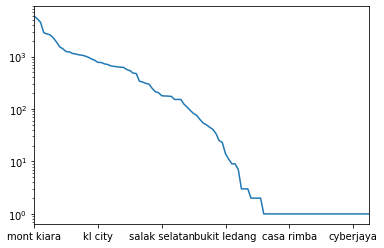

In [13]:
properties["Location"].value_counts().plot(logy=True);

In [14]:
significant_locations = properties["Location"].value_counts()[
    properties["Location"].value_counts() >= 100].index

properties = properties.loc[np.isin(properties["Location"], significant_locations)]

A new look at the locations shows that there are no more ambiguous names.

In [15]:
sorted(properties["Location"].unique())

['ampang',
 'ampang hilir',
 'bandar damai perdana',
 'bandar menjalara',
 'bangsar',
 'bangsar south',
 'batu caves',
 'brickfields',
 'bukit bintang',
 'bukit jalil',
 'bukit tunku (kenny hills)',
 'cheras',
 'city centre',
 'country heights damansara',
 'damansara heights',
 'desa pandan',
 'desa parkcity',
 'desa petaling',
 'dutamas',
 'jalan ipoh',
 'jalan klang lama (old klang road)',
 'jalan kuching',
 'jalan sultan ismail',
 'kepong',
 'keramat',
 'kl city',
 'kl eco city',
 'kl sentral',
 'klcc',
 'kuchai lama',
 'mont kiara',
 'oug',
 'pandan perdana',
 'pantai',
 'salak selatan',
 'segambut',
 'sentul',
 'seputeh',
 'setapak',
 'setiawangsa',
 'sri hartamas',
 'sri petaling',
 'sungai besi',
 'sunway spk',
 'taman desa',
 'taman melawati',
 'taman tun dr ismail',
 'titiwangsa',
 'wangsa maju']

## Number of Rooms
The number of rooms contains some irregularities. For example, it is common for rooms to be listed as N+M instead of the total number of rooms. I want to clean the `Rooms` column and introduce a numerical equivalent.

In [16]:
sorted(properties["Rooms"].unique().astype(str))

['1',
 '1+1',
 '1+2',
 '10',
 '10+',
 '10+1',
 '11',
 '11+1',
 '12',
 '12+',
 '13',
 '13+',
 '13+1',
 '14',
 '15+',
 '16',
 '18',
 '2',
 '2+1',
 '2+2',
 '20 Above',
 '3',
 '3+1',
 '3+2',
 '4',
 '4+1',
 '4+2',
 '5',
 '5+1',
 '5+2',
 '6',
 '6+',
 '6+1',
 '7',
 '7+',
 '7+1',
 '8',
 '8+',
 '8+1',
 '9',
 '9+',
 '9+1',
 'Studio',
 'nan']

In [17]:
def convert_room_num(rooms):
    try:
        if rooms.endswith("+"):
            return int(rooms[:-1])
        if re.search("[0-9]+\+[0-9]+", rooms) is not None:
            tmp = rooms.split("+")
            return int(tmp[0]) + int(tmp[1])
        if rooms == "20 Above":
            return 20
        if rooms == "Studio":
            return 1
        return int(rooms)
    except AttributeError:
        return rooms

properties["Rooms Num"] = properties["Rooms"].apply(convert_room_num)

In [18]:
properties["Rooms Num"].value_counts(dropna=False)

3.0     15938
4.0     13027
5.0      6827
2.0      6547
6.0      3747
1.0      3191
7.0      1564
NaN      1560
8.0       361
9.0       102
10.0       45
12.0       14
11.0        8
20.0        7
13.0        4
14.0        3
16.0        2
18.0        1
15.0        1
Name: Rooms Num, dtype: int64

# Property Type
There are several different property types that are typical for Malaysia. A brief glance at the full list  of property types seems overwhelming at first.

In [19]:
properties["Property Type"].value_counts()

Condominium                                  11447
Serviced Residence                            7176
Condominium (Corner)                          5687
Condominium (Intermediate)                    5113
Serviced Residence (Intermediate)             3255
Serviced Residence (Corner)                   2371
2-sty Terrace/Link House (Intermediate)       2361
Bungalow                                      1666
2-sty Terrace/Link House                       981
3-sty Terrace/Link House (Intermediate)        928
Bungalow (Intermediate)                        927
Semi-detached House (Intermediate)             887
Semi-detached House                            821
Bungalow (Corner)                              673
Apartment                                      672
Apartment (Intermediate)                       647
1-sty Terrace/Link House (Intermediate)        488
2-sty Terrace/Link House (Corner)              457
2.5-sty Terrace/Link House (Intermediate)      444
Residential Land               

I can greatly simplify the property types, however, by trimming information. For example, there are many different variations of the Terrace/Link houses that can be grouped together. I create a new category of only the property type "super groups".

In [20]:
def simplify_property_type(prop_type):
    super_types = [
        "Terrace/Link House", "Serviced Residence", "Condominium", 
        "Semi-detached House", "Bungalow", "Apartment", "Townhouse", 
        "Flat", "Residential Land", "Cluster House"]
    for super_type in super_types:
        if re.search(super_type, prop_type, flags=re.IGNORECASE) is not None:
            return super_type
    
    return prop_type

properties["Property Type Supergroup"] = properties["Property Type"].apply(simplify_property_type)

In [21]:
properties["Property Type Supergroup"].value_counts(dropna=False)

Condominium            23149
Serviced Residence     13399
Terrace/Link House      7567
Bungalow                3598
Semi-detached House     2102
Apartment               1621
Residential Land         669
Townhouse                508
Flat                     330
Cluster House              6
Name: Property Type Supergroup, dtype: int64

## Furnishing
The furnishing column thankfully doesn't require any cleaning.

In [22]:
properties["Furnishing"].value_counts(dropna=False)

Partly Furnished    26222
Fully Furnished     13846
NaN                  6687
Unfurnished          5611
Unknown               583
Name: Furnishing, dtype: int64

## Size
The size apparently always has the same structure:

    [Built-up/Land area] : [Value] sq. ft.

In [23]:
properties[["Size"]].sample(25)

,Size
44370,"Built-up : 9,000 sq. ft."
24474,"Built-up : 2,002 sq. ft."
38244,Land area : 3046 sq. ft.
11381,Built-up : 522 sq. ft.
36948,Land area : 1659 sq. ft.
45748,Built-up : 950 sq. ft.
48529,Land area : 6000 sq. ft.
36563,Built-up : 729 sq. ft.
36203,"Built-up : 3,983 sq. ft."
16770,Built-up : 900 sq. ft.


So I will create two new column that indicate whether this is built-up or land area and store the actual square footage.

In [24]:
def split_size(val, index=0):
    try:
        return val.split(":")[index].strip()
    except AttributeError:
        return val
    
properties["Size Type"] = properties["Size"].apply(split_size, index=0)
properties["Size Num"] = properties["Size"].apply(split_size, index=1)

In [25]:
properties["Size Type"].value_counts(dropna=False)

Built-up     37493
Land area    14453
NaN           1003
Name: Size Type, dtype: int64

Now I need to strip the new `Size_num` column and convert it to a numerical value.

In [26]:
def convert_size_num(size):
    # Attempt to trim the numbers down. Most of this is done explicitly without
    # regex to avoid incorrect trimming, which would lead to the concatenation
    # of numbers. I would rather have missing values than incorrectly cleaned
    # numbers.
    try:
        # If it's not in square feet then I don't want to deal with all
        # possible conversions for now.
        if re.search(r"sq\.*\s*ft\.*", size) is None:
            return None
    
        size = size.replace(",", "")
        size = size.replace("'", "")
        size = size.replace("sq. ft.", "")
        size = size.replace("sf", "")
        size = size.strip()
        size = size.lower()
        
        add_mult_match = re.search(r"(\d+)\s*\+\s*(\d+)\s*(?:x|\*)\s*(\d+)", size)
        if add_mult_match is not None:
            return int(add_mult_match.groups()[0]) + (
                int(add_mult_match.groups()[1]) * 
                int(add_mult_match.groups()[2]))
        
        mult_match = re.search(r"(\d+)\s*(?:x|\*)\s*(\d+)", size)
        if mult_match is not None:
            return int(mult_match.groups()[0]) * int(mult_match.groups()[1])
        
        return int(size)
    # If any of the above doesn't work, just turn it into None/NaN
    # We want to guarantee this column is numeric
    except:
        return None
        
properties["Size Num"] = properties["Size Num"].apply(convert_size_num)

Cleaning the property sizes introduced only a small number of additional missing values.

In [27]:
print("Properties with missing raw size data: {}".format(properties["Size"].isna().sum()))
print("Properties with missing size type data: {}".format(properties["Size Type"].isna().sum()))
print("Properties with missing size num data: {}".format(properties["Size Num"].isna().sum()))

Properties with missing raw size data: 1003
Properties with missing size type data: 1003
Properties with missing size num data: 1313


I will synchronize the missing values between the `Size Type` and `Size Num` columns.

In [28]:
properties.loc[properties["Size Num"].isna(), "Size Type"] = None

In [29]:
properties.loc[:, "Size Type"].value_counts(dropna=False)

Built-up     37455
Land area    14181
NaN           1313
Name: Size Type, dtype: int64

## Other columns
The number of bathrooms and car parks are standardized and do not require any further cleaning.

In [30]:
properties["Bathrooms"].value_counts(dropna=False)

2.0     21163
3.0      9331
4.0      6522
5.0      4717
1.0      4482
6.0      3172
NaN      1866
7.0      1031
8.0       402
9.0       142
10.0       70
12.0       14
11.0       11
20.0       10
15.0        6
13.0        5
14.0        4
16.0        1
Name: Bathrooms, dtype: int64

In [31]:
properties["Car Parks"].value_counts(dropna=False)

NaN     17042
2.0     15174
1.0     13622
3.0      3798
4.0      1913
6.0       623
5.0       501
8.0        91
10.0       76
7.0        62
15.0        7
12.0        7
13.0        7
20.0        4
11.0        4
9.0         4
30.0        4
28.0        4
16.0        2
17.0        2
18.0        1
24.0        1
Name: Car Parks, dtype: int64

## Price per Area / Room
As a last step, I want to introduce the price per area and price per rooms as features

In [32]:
properties["Price per Area"] = properties["Price"] / properties["Size Num"]
properties["Price per Room"] = properties["Price"] / properties["Rooms Num"]

## Save Preprocessed Data

In [33]:
properties.to_csv("Properties_preprocessed.csv")

# Data Exploration

The most immediate question will be how properties differ between neighborhoods in their characteristics.

In [34]:
def plot_by_neighborhood(feature, formatting, factor=1):
    df = properties.groupby("Location")[feature].median().sort_values(ascending=False).reset_index()
    shift = 0.1 * (df[feature].max() - df[feature].min())
    df_sizes = properties.groupby("Location").size()[df["Location"]]

    fig = sns.catplot(
        data=df, x=feature, y="Location", kind="bar", 
        color="darkgrey", height=10, aspect=0.8)

    for index, row in df.iterrows():
        fig.ax.text(
            row[feature] + shift, row.name, formatting.format(row[feature] / factor), 
            color='black', ha="center", va="center")

    fig.ax.get_xaxis().set_visible(False);
    fig.despine(left=True, bottom=True)
    fig.ax.tick_params(left=False, bottom=False);
    fig.set_ylabels("");

## Total Prices per Neighborhood

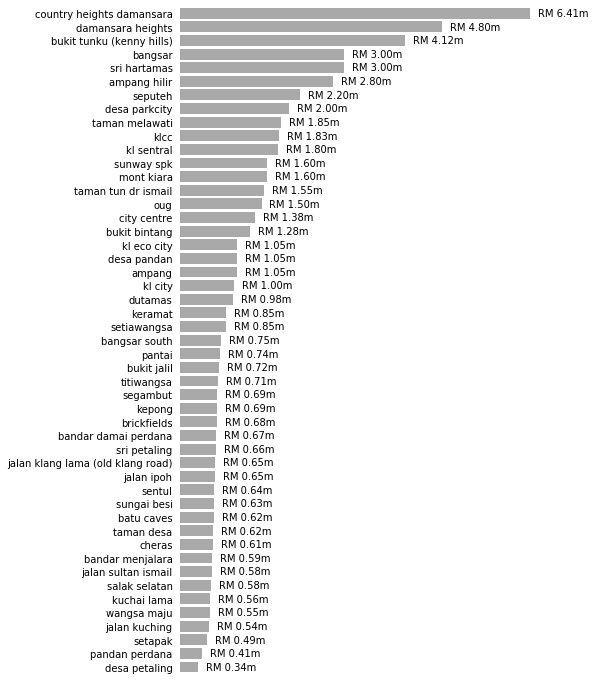

In [35]:
plot_by_neighborhood(feature="Price", formatting="RM {:.2f}m", factor = 1e6)

## Price per Square Foot per Neighborhood

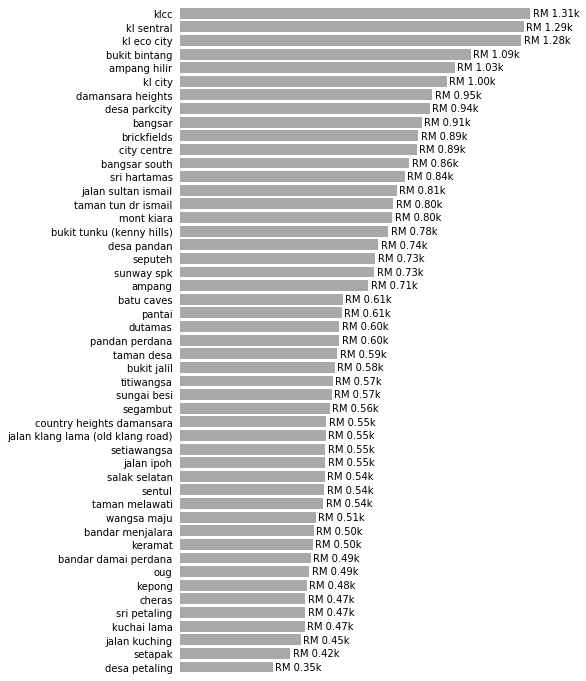

In [36]:
plot_by_neighborhood(feature="Price per Area", formatting="RM {:.2f}k", factor = 1e3)

## Price per Room per Neighborhood

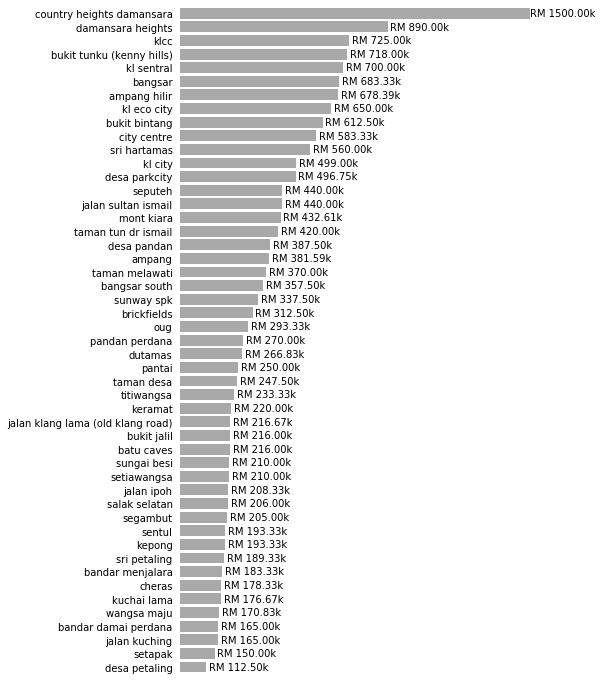

In [37]:
plot_by_neighborhood(feature="Price per Room", formatting="RM {:.2f}k", factor = 1e3)

## Property Size per Neighborhood

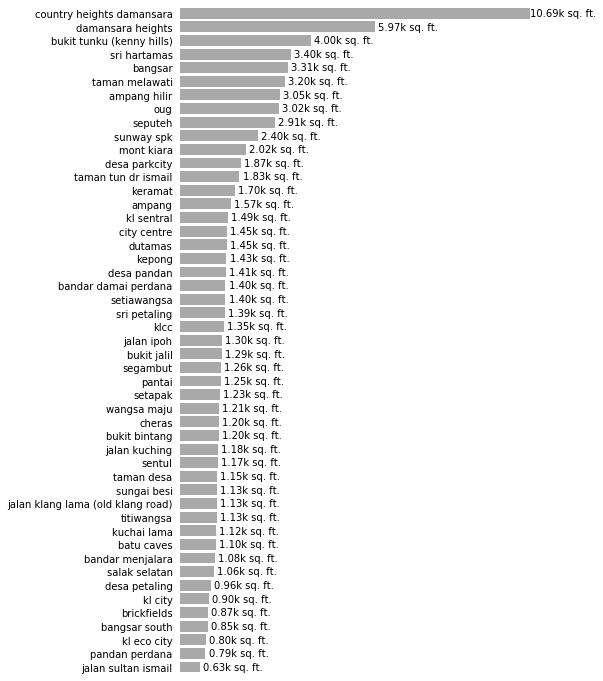

In [38]:
plot_by_neighborhood(feature="Size Num", formatting="{:.2f}k sq. ft.", factor = 1e3)

## Rooms per Neighborhood

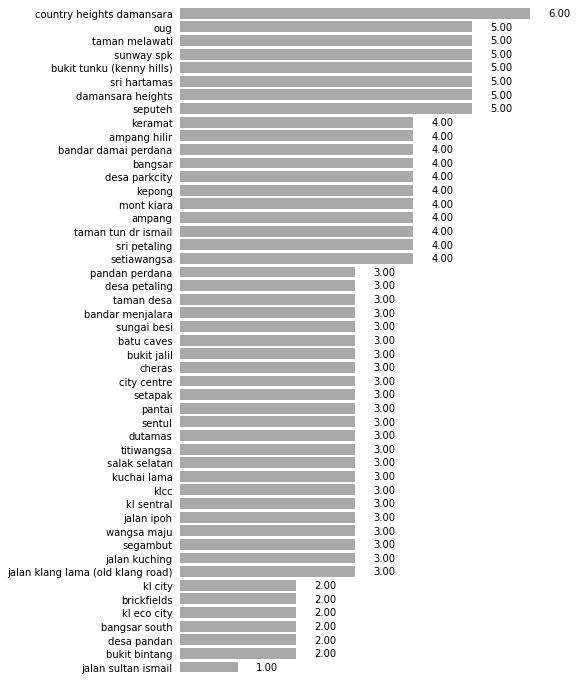

In [39]:
plot_by_neighborhood(feature="Rooms Num", formatting="{:.2f}", factor = 1)

## Number of Properties per Neighborhood

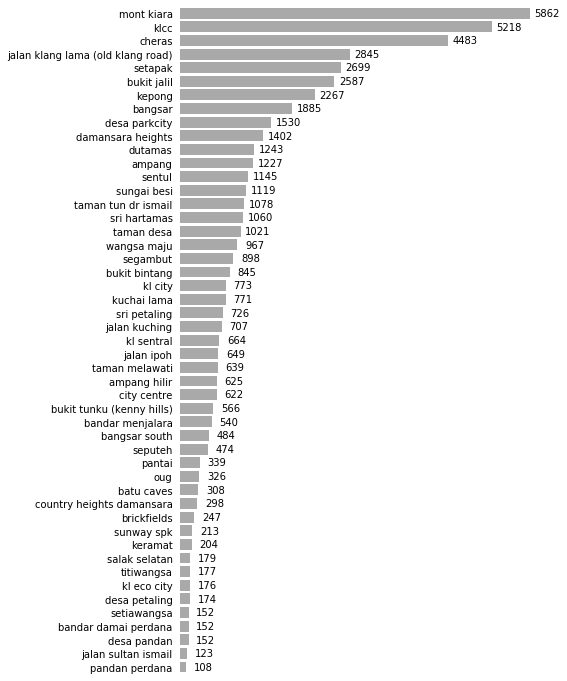

In [40]:
df = properties.groupby("Location").size().sort_values(ascending=False).reset_index()
shift = 0.05 * (df[0].max() - df[0].min())
df_sizes = properties.groupby("Location").size()[df["Location"]]

fig = sns.catplot(
    data=df, x=0, y="Location", kind="bar", 
    color="darkgrey", height=10, aspect=0.8)

for index, row in df.iterrows():
    fig.ax.text(
        row[0] + shift, row.name, row[0], 
        color='black', ha="center", va="center")

fig.ax.get_xaxis().set_visible(False);
fig.despine(left=True, bottom=True)
fig.ax.tick_params(left=False, bottom=False);
fig.set_ylabels("");

## Most common Property Type per Neighborhood

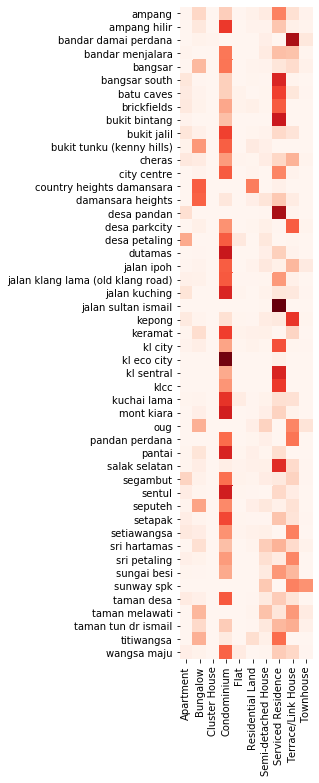

In [41]:
# Extract property type and turn it into a two-column data frame
df = properties.loc[~properties["Property Type Supergroup"].isna()].groupby(
    "Location")["Property Type Supergroup"].value_counts()
df.name = "Value"
df = df.reset_index().pivot(index="Location", columns="Property Type Supergroup")
df.columns = df.columns.droplevel(0)
df = df.fillna(0)

# normalize rows to see relative amount of properties in each neighborhood 
df_norm = df.apply(lambda x: x / x.sum(), axis=1)

fix, ax = plt.subplots(figsize=(12, 12))
hmap = sns.heatmap(
    df_norm, square=True, vmin=0, cmap="Reds", ax=ax, cbar=False)
hmap.set_ylabel(None);
hmap.set_xlabel(None);

## Land vs. Built-Up Area per Neighborhood

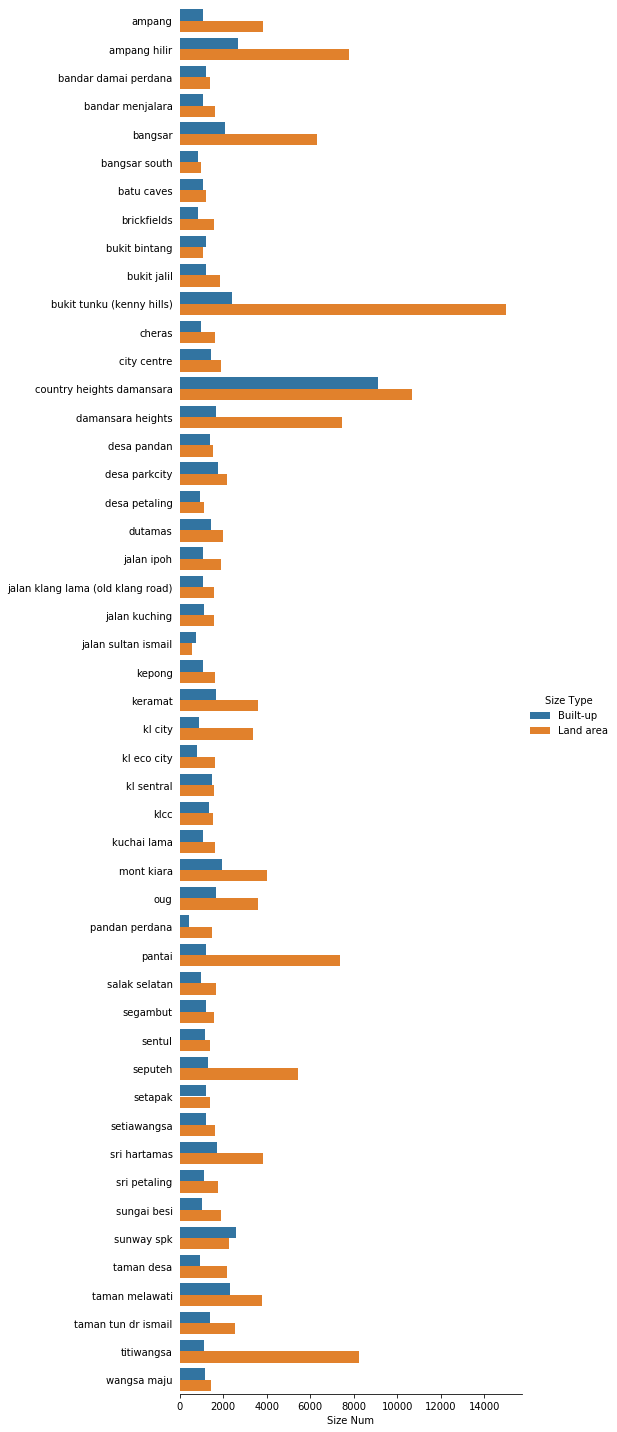

In [42]:
df = properties[["Location", "Size Type", "Size Num"]].groupby(
    ["Location", "Size Type"]).median().reset_index()
fig = sns.catplot(
    data=df, x="Size Num", y="Location", kind="bar", 
    hue="Size Type", height=20, aspect=0.4);

fig.despine(left=True)
fig.ax.tick_params(left=False);
fig.set_ylabels("");

# Predictive Modelling

## Preparing the Data
As a short exercise in predictive modelling, I want to try to predict the price of a property based on the characteristics listed here. Due to the heterogeneity of the data, I will only look at a subset of the property listings to reduce the number of potentially confounding factors. In particular, I will:

- Look only at entries with "built-up" area listed. This is because built-up size and land area are, strictly speaking, two different features.
- Look only at entries without missing values for features (see below for a detailed description of which features I use).

I will also be selective aboutt he features I include in the model. As categorical features would have to be converted to dummy features, e.g. the `Rooms` feature would be converted to boolean "has_3_rooms", "has_3+1_rooms", etc., I will try to use numerical versions of the features where possible. Specifically, the following features will _not_ be used:

- `Rooms`, which will be replaced with `Rooms Num`
- `Size`, which will be replaced with `Size Num`
- `Size Type`, as this will always be "built-up" in the reduced data frame)
- `Property Type`, as there are simply too many variants. I instead use `Property Type Supergroup`.

This means our model will consider the following features:

- `Location` (converted to binary dummy features)
- `Bathrooms`
- `Car Parks`
- `Furnishing`
- `Rooms Num`
- `Property Type Supergroup`
- `Size Num`

And the model will be trained to predict any of the three price columns, `Price`, `Price per Area`, and `Price per Room`.

Lastly, I will make the assumption that a missing entries for `Car Parks` is 0. While not necessarily true, it is likely to be the case for many entries. However, I will not make the same assumption for `Bathrooms`, as a (built up) property will have at least one bathroom.

In [43]:
# Remove entries with "land area" in the "Size Type" column
Xy = properties.loc[properties["Size Type"] == "Built-up"]

# Keep only the relevant features
Xy = Xy.loc[:, [
    "Location", "Bathrooms", "Car Parks", "Furnishing", 
    "Rooms Num", "Property Type Supergroup", "Size Num", 
    "Price", "Price per Area", "Price per Room"]]

# Fill missing Car Parks feature values
Xy.loc[:, "Car Parks"] = Xy["Car Parks"].fillna(0)

# Remove entries with missing values
Xy = Xy.loc[Xy.isna().sum(axis=1) == 0]

# Specifically remove entries with "Unknown" furnishing status
Xy = Xy.loc[Xy["Furnishing"] != "Unknown"]

# Convert to dummy features
Xy = pd.get_dummies(Xy)

In [44]:
print("Shape of data frame: {}".format(Xy.shape))

Shape of data frame: (32413, 68)


The data frame now consists of only numerical features:

In [45]:
print("Data frame DTYPES:")
for dtype in Xy.dtypes.unique():
    print(" - {}".format(dtype))

Data frame DTYPES:
 - float64
 - int64
 - uint8


## Feature Selection
Beyond the intial preprocessing, I obviously want to perform feature selection as well. Some features may be heavily correlated.

### Outlier removal
The first step is to remove outliers from the original numerical features. Until now, I've used a robust aggregator (the median) and outliers have been irrelevant, but they can become a thorn in our side for predictive modelling.

I remove `Size Num` outliers heuristically. The smallest reasonable value, as can be seen from the data, corresponds to $250$ square feet. This corresponds to a small studio apartment. Ergo I use this as the lower threshold for potential values.

In [46]:
Xy["Size Num"].sort_values().head(10)

7724      11.0
26309    250.0
44334    250.0
43156    250.0
23544    250.0
49397    250.0
53436    250.0
33466    250.0
42080    250.0
52309    250.0
Name: Size Num, dtype: float64

On the opposite end of the spectrum, there appear to be several unreasonably large properties ($820000$ square feet corresponds to the approximate size of the Louvre museum in Paris, France). I heuristically set the cutoff at $20000$ square feet for the maximum size of a property.

In [47]:
Xy["Size Num"].sort_values(ascending=False).head(20)

26310    820000.0
2437     790000.0
23507    690000.0
9339     576000.0
50850    320015.0
43550    166821.0
50824     60000.0
28733     50000.0
21072     23716.0
45085     19180.0
28888     18222.0
43686     17000.0
19070     17000.0
12089     16500.0
27843     15000.0
52747     14875.0
4688      14570.0
38448     14410.0
51742     13939.0
44945     13000.0
Name: Size Num, dtype: float64

In [48]:
Xy = Xy.loc[Xy["Size Num"].between(250, 20000)]

From the remaining three originally numerical columns, `Bathrooms`, `Car Parks`, and `Rooms Num`, I trim the top and bottom $0.1\%$ of all entries.

In [49]:
selectors = []
for feature in ["Bathrooms", "Car Parks", "Rooms Num"]:
    selectors.append(Xy[feature].between(
        Xy[feature].quantile(0.001), 
        Xy[feature].quantile(0.999)))

Xy = Xy.loc[(~pd.DataFrame(selectors).T).sum(axis=1) == 0]

All further feature selection will be performed on a subset of the data that will _not_ be used for training the model itself to avoid overfitting.

In [50]:
Xy, Xy_feature_selection = sklearn.model_selection.train_test_split(
    Xy, test_size=0.25, random_state=101)

In [51]:
Xy.shape

(24260, 68)

In [52]:
Xy_feature_selection.shape

(8087, 68)

### Feature Scaling
First, the original numerical features must be scaled (the binary dummy features don't need to be scaled).

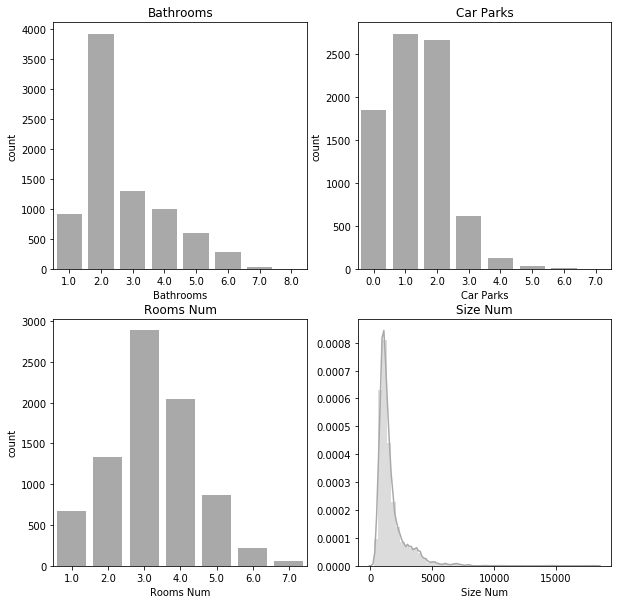

In [53]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10));
sns.countplot(data=Xy_feature_selection, x="Bathrooms", ax=ax[0, 0], color="darkgrey");
ax[0, 0].set_title("Bathrooms");
sns.countplot(data=Xy_feature_selection, x="Car Parks", ax=ax[0, 1], color="darkgrey");
ax[0, 1].set_title("Car Parks");
sns.countplot(data=Xy_feature_selection, x="Rooms Num", ax=ax[1, 0], color="darkgrey");
ax[1, 0].set_title("Rooms Num");
sns.distplot(a=Xy_feature_selection["Size Num"], bins=50, ax=ax[1, 1], color="darkgrey");
ax[1, 1].set_title("Size Num");

As none of the features seem to be normally distributed, I will simply scale them to lie between 0 and 1. Note that the data sets for training and feature selection are scaled separately!

In [54]:
cols = ["Bathrooms", "Car Parks", "Rooms Num", "Size Num"]
Xy_feature_selection[cols] = sklearn.preprocessing.MinMaxScaler().fit_transform(
    Xy_feature_selection[cols])
Xy[cols] = sklearn.preprocessing.MinMaxScaler().fit_transform(Xy[cols])

### Feature Correlation
I look at the correlation between the initial numerical features to determine if they can be pruned.

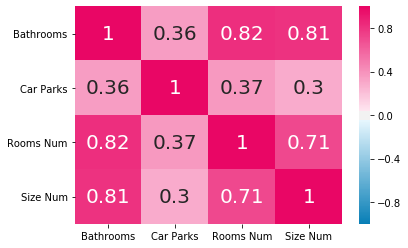

In [55]:
hm_cmap = sns.diverging_palette(240, 0, s=99, l=50, as_cmap=True)
df = Xy_feature_selection[["Bathrooms", "Car Parks", "Rooms Num", "Size Num"]].corr()
sns.heatmap(data=df, vmin=-1, vmax=1, cmap=hm_cmap, annot=df, annot_kws={"size": 20});

Based on the above correlation matrix, the features `Bathrooms` and `Rooms Num` both correlate very strongly with `Size Num` and can be safely removed.

Remove the actual features from the dataset(s)

In [56]:
Xy = Xy.drop(["Bathrooms", "Rooms Num"], axis=1)
Xy_feature_selection = Xy_feature_selection.drop(["Bathrooms", "Rooms Num"], axis=1)

In addition to the features, I also want to look at the potential target variables and how they correlate.

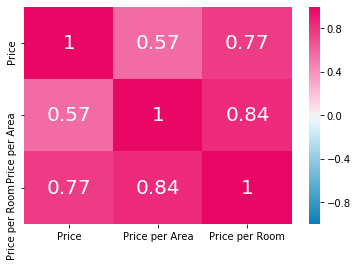

In [57]:
df = Xy_feature_selection[["Price", "Price per Area", "Price per Room"]].corr()
sns.heatmap(
    df, vmin=-1, vmax=1, cmap=hm_cmap, 
    annot=np.round(df, 2), annot_kws={"size": 20})

`Prive per Area` and `Price per Room` correlate very strongly so that it makes little sense to retain both. I consequently remove `Price per Room`.

In [58]:
Xy = Xy.drop("Price per Room", axis=1)
Xy_feature_selection = Xy_feature_selection.drop("Price per Room", axis=1)

## Modelling

Split data into training and test set

In [59]:
Xy_train, Xy_test = sklearn.model_selection.train_test_split(Xy, test_size=0.2, random_state=101)
X_train = Xy_train.drop(["Price", "Price per Area"], axis=1)
y_train = Xy_train[["Price", "Price per Area"]]
X_test = Xy_test.drop(["Price", "Price per Area"], axis=1)
y_test = Xy_test[["Price", "Price per Area"]]

Define convenience function to train and test a `scikit-learn` model.

In [60]:
def train_and_test_model(
        model, X_train=X_train, y_train=y_train, 
        X_test=X_test, y_test=y_test, **kwargs):
    model.fit(X_train, y_train, **kwargs)
    y_pred = model.predict(X_test)
    r2 = sklearn.metrics.r2_score(y_true=y_test, y_pred=y_pred)
    return model, r2

In [61]:
model, r2 = train_and_test_model(
    model = sklearn.linear_model.LinearRegression(), 
    X_train=X_train, y_train=y_train["Price"], 
    X_test=X_test, y_test=y_test["Price"])
print("R^2 for prediction of 'Price': {:.2f}".format(r2))

model, r2 = train_and_test_model(
    model = sklearn.linear_model.LinearRegression(), 
    X_train=X_train, y_train=y_train["Price per Area"], 
    X_test=X_test, y_test=y_test["Price per Area"])
print("R^2 for prediction of 'Price per Area': {:.2f}".format(r2))

R^2 for prediction of 'Price': 0.67
R^2 for prediction of 'Price per Area': 0.51


Neither of the targets can be predicted with a satisfying accuracy. This is most likely due to the overwhelming number of sparse binary features.

In [62]:
def make_fcn_model():
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(units=32, activation="relu", input_shape=(X_train.shape[1],)))
    model.add(keras.layers.Dense(units=32, activation="relu"))
    model.add(keras.layers.Dense(units=32, activation="relu"))
    model.add(keras.layers.Dense(units=1, activation="relu"))
    model.compile(loss="mse", optimizer="Adam")
    return model

In [63]:
model, r2 = train_and_test_model(
    model = make_fcn_model(), 
    X_train=X_train, y_train=y_train["Price"], 
    X_test=X_test, y_test=y_test["Price"], 
    batch_size=8, epochs=10, verbose=0)
print("R^2 for prediction of 'Price': {:.2f}".format(r2))

model, r2 = train_and_test_model(
    model = make_fcn_model(), 
    X_train=X_train, y_train=y_train["Price per Area"], 
    X_test=X_test, y_test=y_test["Price per Area"], 
    batch_size=8, epochs=10, verbose=0)
print("R^2 for prediction of 'Price per Area': {:.2f}".format(r2))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
R^2 for prediction of 'Price': 0.39
R^2 for prediction of 'Price per Area': 0.55


# Conclusion
Neither a linear model nor a neural network perform sufficiently well in predicting property prices. This is unsurprising, of course, as properties are much more complex than the features captured here indicate. In particular, the summary statistics seen in the EDA show that the neighborhood alone accounts for massive differences in property prices. The remaining features used here, e.g. the property size or the number of rooms, cannot account for all variance within. A proper price prediction model for new properties would therefore require more detailed features as scraped from the property listing itself rather than just the overview page as I've done here.